In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools

import deepchem as dc

In [2]:
bbb_df = pd.read_csv('adenot_processed.csv')

## Optimized XGB

In [3]:
xg_best = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.85,
 reg_alpha=1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,)

## Scaffold Split

In [4]:
Xs = bbb_df.iloc[:,3:].copy()
Ys = bbb_df.iloc[:,2].copy()
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,ids=bbb_df['SMILES'].tolist())
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train_scaff, test_scaff = scaffoldsplitter.train_test_split(dataset)

## Model Training and Predictions

In [5]:
# Train Decision Tree classifier
xg_best = xg_best.fit(train_scaff.X,train_scaff.y)

In [6]:
# Predict the response for test dataset
y_pred_scaff = xg_best.predict(test_scaff.X)

In [7]:
y_pred_scaff_prob = xg_best.predict_proba(test_scaff.X)

prob_test_df = pd.DataFrame()
prob_test_df['SMILES'] = test_scaff.ids
prob_test_df['Prob Permeable'] = y_pred_scaff_prob[:,1]
prob_test_df = prob_test_df.sort_values(by=['Prob Permeable'], ascending=False)
prob_test_df

,SMILES,Prob Permeable
151,CC1CCCCC1(N1CCCCC1)c1sccc1,0.999999
25,Clc1ccccc1C1=NCc2nnc(n2c2sc(cc12)Br)C1CCCCC1,0.999998
65,CN1CCC(CC1)=C1c2ccsc2CCc2ccccc12,0.999997
62,C1CN2CCC1C(C2)N1c2ccccc2CCc2ccccc12,0.999995
54,CCn1c2ccccc2c2c1C(C)(CCN(C)C)SCC2,0.999992
...,...,...
275,CC1(C)S[C@@H]2[C@H](NC(=O)C34CC5CC(CC(N)(C5)C3...,0.000121
204,CC[C@H](C(=O)NC/C=C/C=C(\C)/[C@@H](OC)[C@@H](C...,0.000119
246,CO\N=C(\C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000095
270,N[C@@H](C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000045


## Feature Importances

In [8]:
# get importance
dt_importance = xg_best.feature_importances_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

Text(0.5, 1.0, 'Top 10 XGBoost Feature Importances')

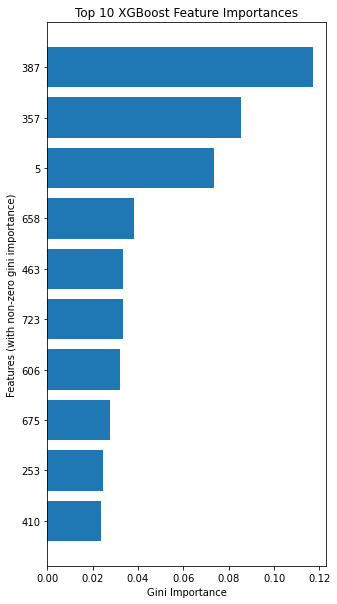

In [9]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][-10:], feature_importance['Importance'][-10:])
plt.title('Top 10 XGBoost Feature Importances')

## Fragment Extraction

In [10]:
def get_fragments(smiles_set, feature_list):
    fragments_df = pd.DataFrame(columns=['Fragment', 'Count'])
    r=2
    d=1024
    for smile in smiles_set:
        m = Chem.MolFromSmiles(smile)
        info={}
        fp = AllChem.GetMorganFingerprintAsBitVect(m,r,d,bitInfo=info)
        fragments = []
        for bit in info.keys():
            if bit in feature_list:
                root_atom = info[bit][0][0]
                radius = info[bit][0][1]
                env = Chem.FindAtomEnvironmentOfRadiusN(m,radius,root_atom)
                amap={}
                submol=Chem.PathToSubmol(m,env,atomMap=amap)
                if amap:
                    fragment = Chem.MolToSmiles(submol, rootedAtAtom=amap[root_atom],canonical=False)
                else:
                    fragment = Chem.MolToSmiles(submol)
                fragments.append(fragment)
        
        for fragment in fragments:
            if fragment in fragments_df['Fragment'].values:
                index = fragments_df.index[fragments_df['Fragment'] == fragment]
                fragments_df.at[index[0],'Count'] = fragments_df.at[index[0],'Count'] + 1
            else:
                row = {'Fragment': [fragment], 'Count': [1]}
                row_df = pd.DataFrame(data=row)
                fragments_df = pd.concat([fragments_df, row_df], ignore_index=True)
    return fragments_df

In [11]:
important_feature_list = np.array(feature_importance['Feature'].values).astype(int)
important_feature_list

array([ 226,  250,  650,   64,  294,  695,  175,  557,  726,  926,  679,
         33,  881,  935, 1017,  875,  268,  656,   84,   80,  147, 1019,
        389,  893,  283,  456,  222,  301,    1,  378,   90,  314,  714,
         36,  946,  356,  341,  362,  121,  519,  128,  485,  392,  816,
        841,  967,  698,   15,  659,  114,  102,  849,  807,  745,  231,
        333,  428,  130,  904,  138,  887,  673,  285,  233,  739,  227,
        767,  237,  249,  352,  271,  406,  412,  583,  484,  580,  667,
        829,  116,  193,  687,  578,  255,    0,  611,  753,  317,  638,
        897,  202,  125,  981,  936,  452,  464,  299,  272,  338,  212,
        410,  253,  675,  606,  723,  463,  658,    5,  357,  387])

### 1.1 Fragment Extraction For Top 50 Probability Predictions, Using All Important Features

In [12]:
top_50 = prob_test_df['SMILES'].tolist()[:50]
fragments_prob_high = get_fragments(top_50, important_feature_list)

In [13]:
fragments_prob_high = fragments_prob_high.sort_values(by=['Count'], ascending=False)
fragments_prob_high.head(20)

,Fragment,Count
0,,368
1,c(c)c,103
6,c(cc)cc,50
2,C(C)C,34
5,C(N)C,25
4,CC,15
9,CN,14
12,C(C)N,14
10,c(C)(c)c,13
33,O=C,8


### 1.2 Fragment Extraction For Lowest 50 Probability Predictions

In [14]:
low_50 = prob_test_df['SMILES'].tolist()[-50:]
fragments_prob_low = get_fragments(low_50, important_feature_list)

In [15]:
fragments_prob_low = fragments_prob_low.sort_values(by=['Count'], ascending=False)
fragments_prob_low.head(20)

,Fragment,Count
0,,687
9,O=C,96
2,c(c)c,58
14,OC,54
13,N(C)C,45
7,CC,42
42,[C@H]1(NC)[C@@H](S)NC1=O,36
5,c(cc)cc,24
35,C(N)(=O)C,22
24,C(C)C,21


### 2.1 Fragment Extraction for Permeable Molecules in Dataset, Using Top 20 Most Important Features

In [16]:
fragments_perm = get_fragments(bbb_df[bbb_df['permeable'] == 1]['SMILES'], important_feature_list[-20:])

In [17]:
fragments_perm = fragments_perm.sort_values(by=['Count'], ascending=False)
fragments_perm.head(20)

,Fragment,Count
15,,133
11,c(C)(c)c,63
19,c(c)(c)C,56
16,c(c)(C)c,46
34,O=S,37
48,N(C)(CC)CC,29
24,NC,16
32,c(cc)(cc)F,14
13,N(C)C,12
20,C(N)(=O)C,11


### 2.1 Fragment Extraction for Non-Permeable Molecules in Dataset, Using Top 20 Most Important Features

In [18]:
fragments_nonperm = get_fragments(bbb_df[bbb_df['permeable'] == 0]['SMILES'], important_feature_list[-20:])

In [19]:
fragments_nonperm = fragments_nonperm.sort_values(by=['Count'], ascending=False)
fragments_nonperm.head(20)

,Fragment,Count
19,,151
5,N(C)C,139
74,C(C)(=O)N,77
2,C(N)(=O)C,70
17,C(C)(O)C,65
79,C(C(=C)N)(O)=O,59
15,O(C)C,58
20,C(O)(O)C,37
75,C(C)(C)(S)C,31
14,c(c)(c)O,27


## Example: Visualizing Fragments

[19:09:11] SMILES Parse Error: syntax error while parsing: CLC
[19:09:11] SMILES Parse Error: Failed parsing SMILES 'CLC' for input: 'CLC'


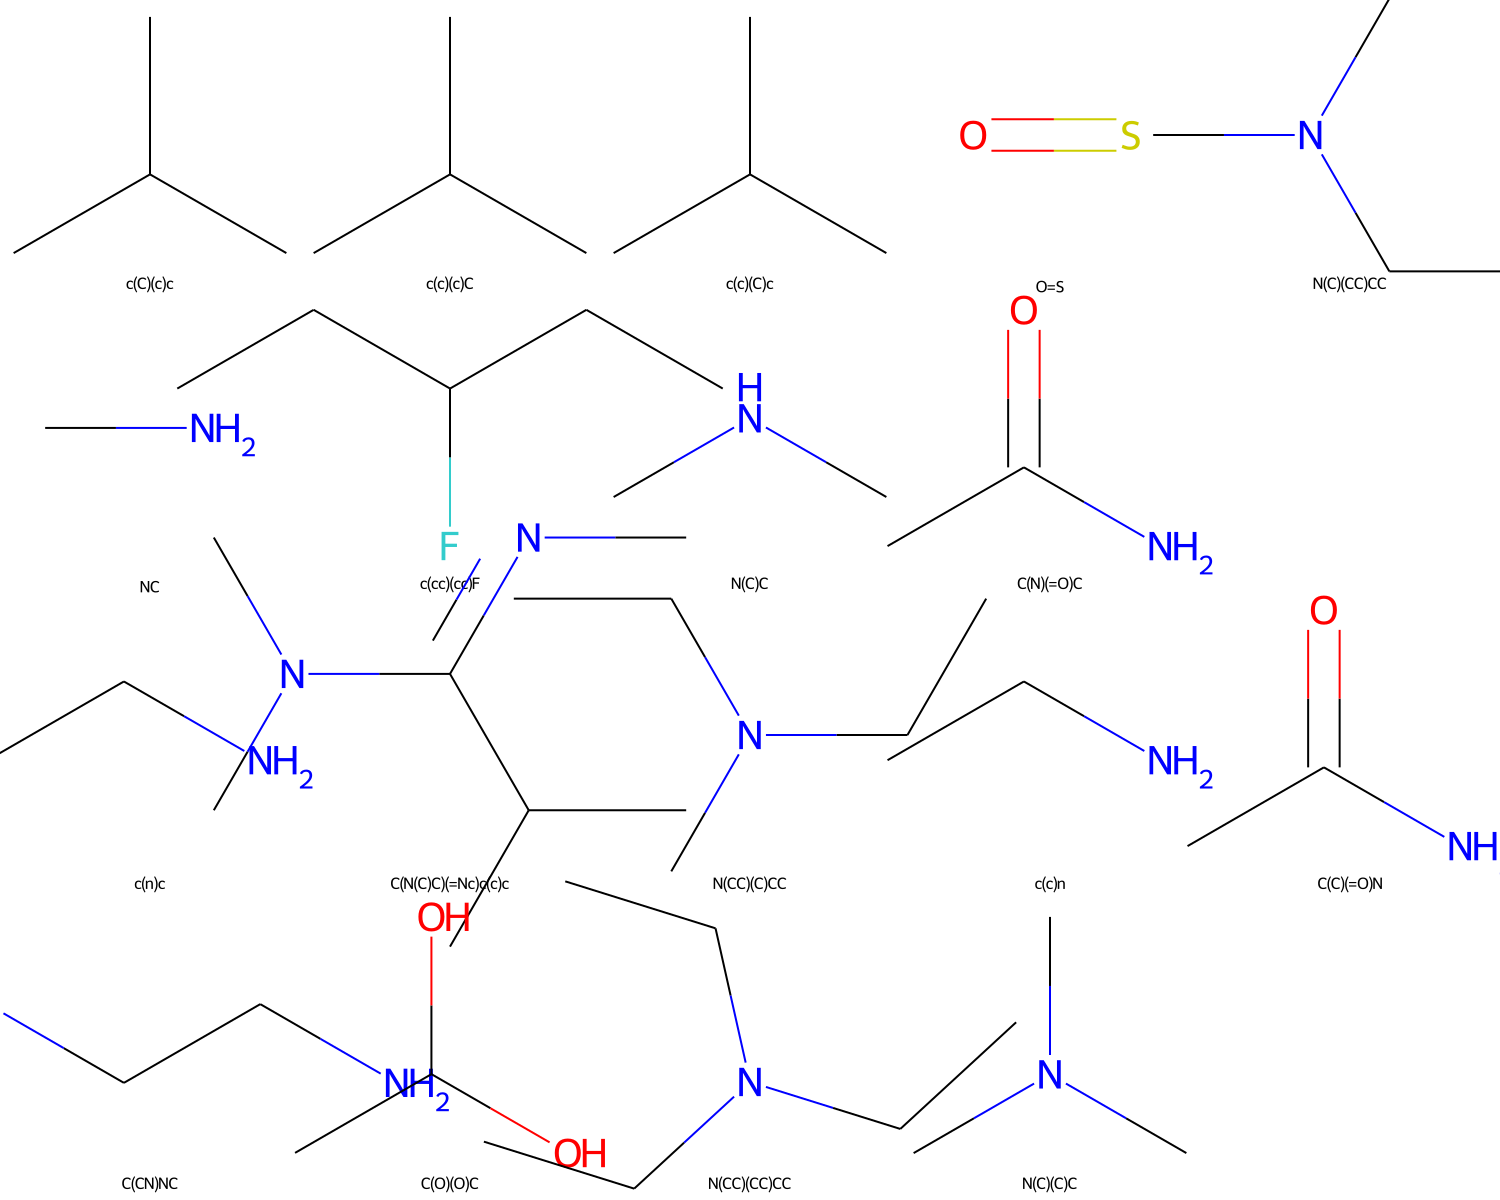

In [20]:
smile_lst = fragments_perm['Fragment'].tolist()[1:20]
smile_lst_upp = [s.upper() for s in smile_lst]

mol_lst = [Chem.MolFromSmiles(s) for s in smile_lst_upp]

from rdkit.Chem import (
    AllChem,
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys
)

Draw.MolsToGridImage(
    mol_lst, 
    molsPerRow=5, 
    subImgSize=(300, 300), 
    legends= smile_lst
)